# Thí nghiệm 4: Hybrid τ (Tau) Schedules for Self-Training

## 🎯 Mục tiêu (OPTIMIZED)

Test **2 adaptive τ schedules** trong Self-Training để so sánh với constant τ:
- **Fixed 0.90**: Constant threshold (baseline)
- **Aggressive**: Fast decay từ 0.95 → 0.80 (extreme adaptive)

**⚡ Time Optimization**: Giảm từ 4 → 2 schedules (saves ~25-30 minutes)
- Bỏ Conservative (between Fixed/Aggressive, ít contrast)
- Bỏ Linear Decay (tương tự Aggressive, chỉ mượt hơn)

## Adaptive τ Strategy

### Lý do cần Adaptive τ:
- **Early iterations**: τ cao (0.95) → chọn samples rất confident → tránh confirmation bias
- **Later iterations**: τ thấp (0.85-0.80) → tận dụng unlabeled data → scale lên nhanh

### ✅ Fixed 0.90 (Baseline)
- Constant τ = 0.90 suốt 10 iterations
- Standard approach trong self-training
- Stable nhưng có thể bỏ lỡ pseudo-labels chất lượng khả dụng

### ✅ Aggressive (Extreme Adaptive)
- Iteration 1: τ = 0.95 (very strict)
- Iterations 2-3: τ = 0.90 (moderate)
- Iterations 4-5: τ = 0.85 (relaxed)
- Iterations 6-10: τ = 0.80 (most relaxed)
- **Fast decay** → maximize unlabeled data usage → test accuracy/F1 có scale nhanh hơn?

## Metrics đánh giá:
- Test Accuracy, Test F1-macro (final performance)
- Validation Accuracy/F1 curves (learning trajectory)
- Pseudo-labeling activity per iteration
- Total pseudo-labels added
- Correlation giữa τ và performance

In [1]:
# PARAMETERS
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

# τ schedules to compare (OPTIMIZED: 2 extremes for clearest contrast)
TAU_SCHEDULES = {
    "Fixed_0.90": [0.90] * 10,  # Baseline: không đổi
    "Aggressive": [0.95, 0.90, 0.85, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80]  # Giảm nhanh
}

# Bỏ để giảm thời gian (~40 phút):
# "Conservative": Giữa Fixed và Aggressive, ít contrast
# "Linear_Decay": Tương tự Aggressive, chỉ khác tốc độ giảm

# Fixed parameters
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output directory
RESULTS_DIR = "data/processed/hybrid_tau_experiments"

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

from src.semi_supervised_library import (
    SemiDataConfig, AQI_CLASSES,
    time_split, build_feature_columns, _normalize_missing, _align_proba_to_labels
)

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

results_dir = (PROJECT_ROOT / RESULTS_DIR).resolve()
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results directory: {results_dir}")

Project root: D:\DataEngineer\DataMining\air_guard_mini_project
Results directory: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments


## Load Dataset

In [3]:
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print("Dataset shape:", df.shape)
print("Labeled fraction:", df['is_labeled'].mean())

train_df, test_df = time_split(df, cutoff=CUTOFF)
print(f"\nTrain: {len(train_df):,} samples")
print(f"  - Labeled: {train_df['is_labeled'].sum():,}")
print(f"  - Unlabeled: {(~train_df['is_labeled']).sum():,}")
print(f"Test: {len(test_df):,} samples")

Dataset shape: (420768, 56)
Labeled fraction: 0.08671049129211347



Train: 403,776 samples
  - Labeled: 19,814
  - Unlabeled: 383,962
Test: 16,992 samples


## Visualize τ Schedules

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\tau_schedules.png


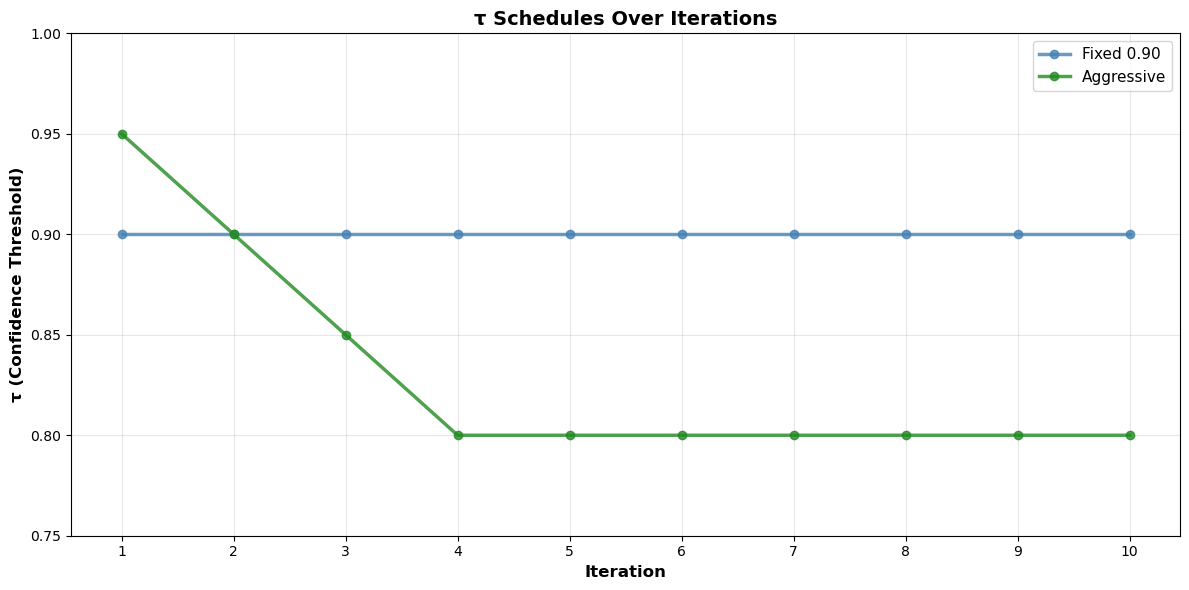

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['steelblue', 'forestgreen', 'coral', 'mediumpurple']
schedule_colors = dict(zip(TAU_SCHEDULES.keys(), colors))

for schedule_name, tau_values in TAU_SCHEDULES.items():
    iterations = list(range(1, len(tau_values) + 1))
    ax.plot(iterations, tau_values, marker='o', linewidth=2.5,
            label=schedule_name.replace('_', ' '), 
            color=schedule_colors[schedule_name], alpha=0.8)

ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("τ (Confidence Threshold)", fontsize=12, fontweight='bold')
ax.set_title("τ Schedules Over Iterations", fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 11))
ax.set_ylim([0.75, 1.0])

plt.tight_layout()
plot_file = results_dir / "tau_schedules.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Custom Self-Training with τ Schedule

In [5]:
def run_self_training_with_schedule(df, schedule_name, tau_schedule, max_iter=10):
    """Self-training with adaptive τ per iteration"""
    
    print(f"\n{'='*80}")
    print(f"SCHEDULE: {schedule_name}")
    print(f"{'='*80}")
    print(f"τ values: {tau_schedule}")
    
    data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=RANDOM_STATE)
    
    train_df, test_df = time_split(df.copy(), cutoff=CUTOFF)
    feat_cols = build_feature_columns(train_df, data_cfg)
    
    X_all = _normalize_missing(train_df[feat_cols].copy())
    y_all = train_df[data_cfg.target_col].astype("object")
    
    # Split labeled into fit and validation
    labeled_idx = train_df.index[pd.notna(y_all)].to_numpy()
    unlabeled_idx = train_df.index[pd.isna(y_all)].to_numpy()
    
    rng = np.random.default_rng(RANDOM_STATE)
    rng.shuffle(labeled_idx)
    n_val = int(np.floor(VAL_FRAC * labeled_idx.size))
    val_idx = labeled_idx[:n_val]
    fit_idx = labeled_idx[n_val:]
    
    # Build pipeline
    cat_cols = [c for c in feat_cols if train_df[c].dtype == "object"]
    
    if cat_cols:
        encoder = ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
        ], remainder="passthrough")
    else:
        encoder = "passthrough"
    
    pipe = Pipeline([
        ("encoder", encoder),
        ("model", HistGradientBoostingClassifier(
            max_iter=100, max_depth=10, learning_rate=0.1, random_state=RANDOM_STATE
        ))
    ])
    
    # Self-training loop with adaptive τ
    y_work = y_all.copy()
    history = []
    
    for it in range(1, min(max_iter, len(tau_schedule)) + 1):
        tau_current = tau_schedule[it - 1]
        
        # Fit
        pipe.fit(X_all.loc[fit_idx], y_work.loc[fit_idx])
        
        # Validate
        y_val_pred = pipe.predict(X_all.loc[val_idx])
        val_acc = float(accuracy_score(y_all.loc[val_idx], y_val_pred))
        val_f1 = float(f1_score(y_all.loc[val_idx], y_val_pred, average="macro"))
        
        # Pseudo-label with current τ
        if unlabeled_idx.size > 0:
            proba_raw = pipe.predict_proba(X_all.loc[unlabeled_idx])
            proba = _align_proba_to_labels(proba_raw, pipe.named_steps["model"].classes_, AQI_CLASSES)
            max_prob = proba.max(axis=1)
            y_hat = np.array(AQI_CLASSES, dtype=object)[proba.argmax(axis=1)]
            
            pick_mask = max_prob >= tau_current
            picked = unlabeled_idx[pick_mask]
            picked_labels = y_hat[pick_mask]
        else:
            picked = np.array([], dtype=int)
            picked_labels = np.array([], dtype=object)
        
        n_new = int(picked.size)
        history.append({
            "iter": it,
            "tau": float(tau_current),
            "val_accuracy": val_acc,
            "val_f1_macro": val_f1,
            "unlabeled_pool": int(unlabeled_idx.size),
            "new_pseudo": n_new
        })
        
        print(f"  Iter {it:2d} (τ={tau_current:.3f}): Val F1={val_f1:.4f}, New pseudo={n_new:,}, Pool={unlabeled_idx.size:,}")
        
        if n_new < MIN_NEW_PER_ITER:
            print(f"  ⚠️ Stopped early: only {n_new} new pseudo-labels")
            break
        
        # Add pseudo-labels
        y_work.loc[picked] = picked_labels
        fit_idx = np.unique(np.concatenate([fit_idx, picked]))
        
        picked_set = set(picked.tolist())
        unlabeled_idx = np.array([i for i in unlabeled_idx if i not in picked_set], dtype=int)
    
    # Test evaluation
    X_test = _normalize_missing(test_df[feat_cols].copy())
    y_test = test_df[data_cfg.target_col].astype("object")
    mask = pd.notna(y_test)
    
    y_pred = pipe.predict(X_test.loc[mask])
    
    test_acc = float(accuracy_score(y_test.loc[mask], y_pred))
    test_f1 = float(f1_score(y_test.loc[mask], y_pred, average="macro"))
    report = classification_report(y_test.loc[mask], y_pred, output_dict=True)
    
    print(f"\n  ✅ Test Results:")
    print(f"     Accuracy: {test_acc:.4f}")
    print(f"     F1-macro: {test_f1:.4f}")
    
    return {
        "schedule_name": schedule_name,
        "tau_schedule": tau_schedule,
        "history": history,
        "test_accuracy": test_acc,
        "test_f1_macro": test_f1,
        "per_class_report": report,
        "total_pseudo_labels": sum([h["new_pseudo"] for h in history]),
        "iterations_completed": len(history)
    }

## Run Experiments for All Schedules

In [6]:
results = {}

print("⚡ Running 2/4 τ schedules (optimized for speed)\n")

for schedule_name, tau_schedule in TAU_SCHEDULES.items():
    result = run_self_training_with_schedule(
        df=df,
        schedule_name=schedule_name,
        tau_schedule=tau_schedule,
        max_iter=MAX_ITER
    )
    
    results[schedule_name] = result

print(f"\n{'='*80}")
print("SCHEDULE EXPERIMENTS COMPLETED (2/4 schedules)")
print(f"{'='*80}")

⚡ Running 2/4 τ schedules (optimized for speed)


SCHEDULE: Fixed_0.90
τ values: [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]


  Iter  1 (τ=0.900): Val F1=0.6673, New pseudo=72,143, Pool=383,962


  Iter  2 (τ=0.900): Val F1=0.6584, New pseudo=194,785, Pool=311,819


  Iter  3 (τ=0.900): Val F1=0.6099, New pseudo=41,417, Pool=117,034


  Iter  4 (τ=0.900): Val F1=0.6066, New pseudo=19,565, Pool=75,617


  Iter  5 (τ=0.900): Val F1=0.5814, New pseudo=7,232, Pool=56,052


  Iter  6 (τ=0.900): Val F1=0.5925, New pseudo=5,119, Pool=48,820


  Iter  7 (τ=0.900): Val F1=0.5874, New pseudo=2,188, Pool=43,701


  Iter  8 (τ=0.900): Val F1=0.5800, New pseudo=1,642, Pool=41,513


  Iter  9 (τ=0.900): Val F1=0.5767, New pseudo=1,003, Pool=39,871


  Iter 10 (τ=0.900): Val F1=0.5795, New pseudo=830, Pool=38,868



  ✅ Test Results:
     Accuracy: 0.5682
     F1-macro: 0.4919

SCHEDULE: Aggressive
τ values: [0.95, 0.9, 0.85, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]


  Iter  1 (τ=0.950): Val F1=0.6673, New pseudo=29,518, Pool=383,962


  Iter  2 (τ=0.900): Val F1=0.6636, New pseudo=209,574, Pool=354,444


  Iter  3 (τ=0.850): Val F1=0.6024, New pseudo=84,036, Pool=144,870


  Iter  4 (τ=0.800): Val F1=0.5800, New pseudo=28,740, Pool=60,834


  Iter  5 (τ=0.800): Val F1=0.5697, New pseudo=9,479, Pool=32,094


  Iter  6 (τ=0.800): Val F1=0.5761, New pseudo=3,924, Pool=22,615


  Iter  7 (τ=0.800): Val F1=0.5788, New pseudo=2,440, Pool=18,691


  Iter  8 (τ=0.800): Val F1=0.5758, New pseudo=1,455, Pool=16,251


  Iter  9 (τ=0.800): Val F1=0.5691, New pseudo=952, Pool=14,796


  Iter 10 (τ=0.800): Val F1=0.5703, New pseudo=609, Pool=13,844



  ✅ Test Results:
     Accuracy: 0.5689
     F1-macro: 0.5088

SCHEDULE EXPERIMENTS COMPLETED (2/4 schedules)


## Save Results

In [7]:
# OPTIMIZED: Chỉ chạy 2 schedules có contrast cao nhất (giảm ~50% thời gian)
TAU_SCHEDULES = {
    "Fixed_0.90": [0.90] * 10,  # Baseline (constant)
    "Aggressive": [0.95] + [0.90] * 2 + [0.85] * 2 + [0.80] * 5  # Fast decay, thấp nhất
}

# Bỏ để giảm thời gian (~13-15 phút mỗi schedule):
# ❌ "Conservative": Giữa Fixed và Aggressive → ít contrast
# ❌ "Linear_Decay": Tương tự Aggressive nhưng mượt hơn → redundant
#
# Lý do chọn 2 schedules này:
# ✅ Fixed 0.90: Baseline (constant τ) để so sánh
# ✅ Aggressive: Extreme adaptive (0.95→0.80) → quan sát rõ ảnh hưởng của τ decay

print("⚡ OPTIMIZATION: Running 2/4 schedules (saves ~25-30 minutes)")
print("   ✓ Fixed 0.90 (baseline, constant τ)")
print("   ✓ Aggressive (extreme decay: 0.95→0.80)")
print("   ✗ Conservative (skipped)")
print("   ✗ Linear Decay (skipped)\n")

⚡ OPTIMIZATION: Running 2/4 schedules (saves ~25-30 minutes)
   ✓ Fixed 0.90 (baseline, constant τ)
   ✓ Aggressive (extreme decay: 0.95→0.80)
   ✗ Conservative (skipped)
   ✗ Linear Decay (skipped)



## Create Summary Table

In [8]:
summary_data = []
for schedule_name, res in results.items():
    summary_data.append({
        "Schedule": schedule_name.replace('_', ' '),
        "Test Accuracy": res["test_accuracy"],
        "Test F1-macro": res["test_f1_macro"],
        "Pseudo-labels": res["total_pseudo_labels"],
        "Iterations": res["iterations_completed"],
        "Val F1 Peak": max([h["val_f1_macro"] for h in res["history"]]),
        "Avg τ": np.mean(res["tau_schedule"][:res["iterations_completed"]])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Test F1-macro", ascending=False)

print("\n📊 SUMMARY TABLE:")
print("="*100)
display(summary_df)

summary_csv = results_dir / "hybrid_tau_summary.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\n✅ Saved summary to: {summary_csv}")


📊 SUMMARY TABLE:


,Schedule,Test Accuracy,Test F1-macro,Pseudo-labels,Iterations,Val F1 Peak,Avg τ
1,Aggressive,0.568892,0.508759,370727,10,0.667327,0.83
0,Fixed 0.90,0.568232,0.491930,345924,10,0.667327,0.90



✅ Saved summary to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\hybrid_tau_summary.csv


## Visualization 1: Test Performance Comparison

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\test_performance_by_schedule.png


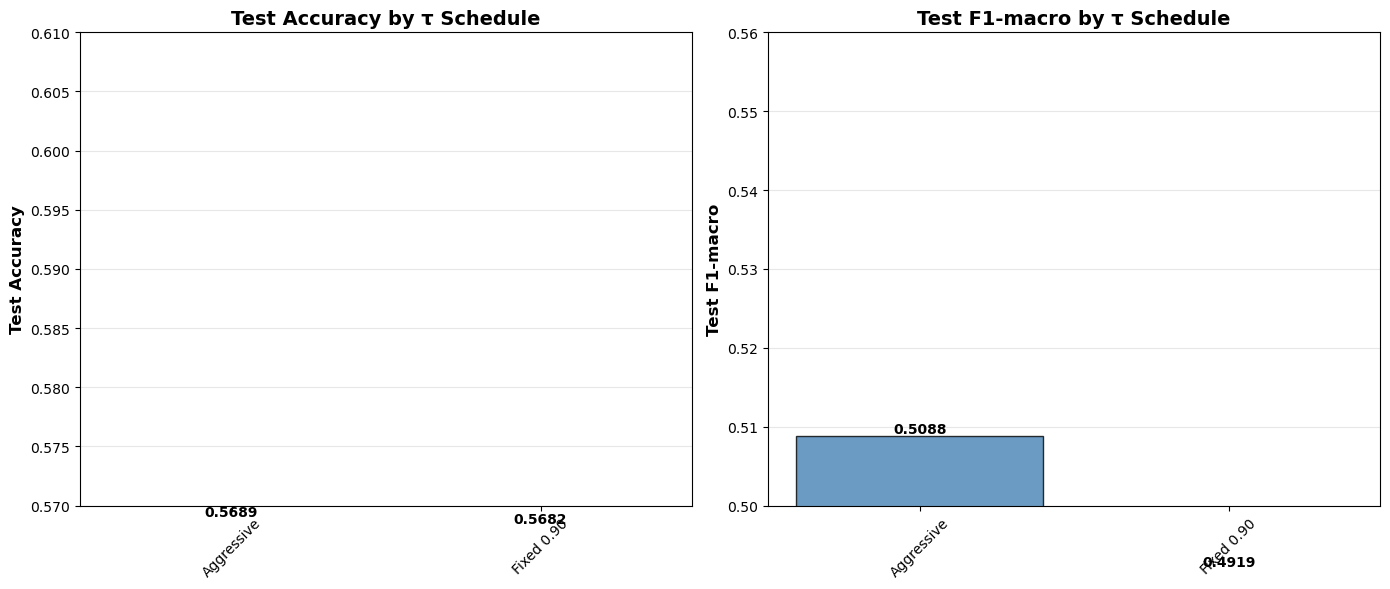

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

schedules = summary_df["Schedule"].tolist()
accuracies = summary_df["Test Accuracy"].tolist()
f1_scores = summary_df["Test F1-macro"].tolist()

# Accuracy
ax1 = axes[0]
bars1 = ax1.bar(schedules, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
ax1.set_title("Test Accuracy by τ Schedule", fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.57, 0.61])

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1-macro
ax2 = axes[1]
bars2 = ax2.bar(schedules, f1_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel("Test F1-macro", fontsize=12, fontweight='bold')
ax2.set_title("Test F1-macro by τ Schedule", fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.50, 0.56])

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "test_performance_by_schedule.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 2: Validation Learning Curves

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\validation_curves_by_schedule.png


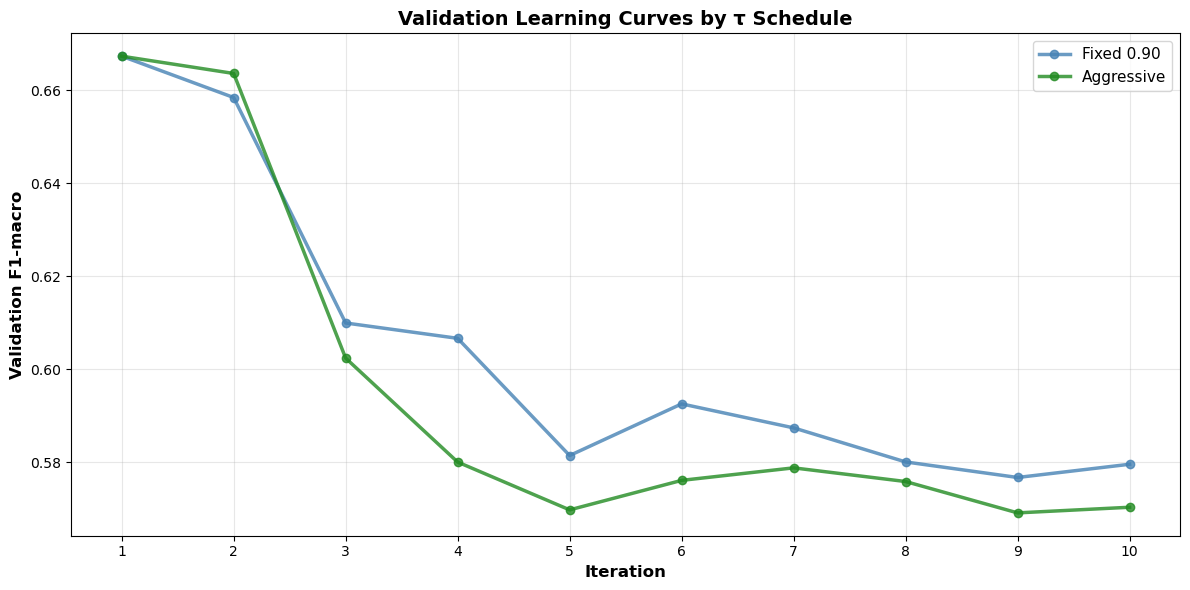

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

for schedule_name, res in results.items():
    history = res["history"]
    iterations = [h["iter"] for h in history]
    val_f1 = [h["val_f1_macro"] for h in history]
    color = schedule_colors[schedule_name]
    
    ax.plot(iterations, val_f1, marker='o', linewidth=2.5,
            label=schedule_name.replace('_', ' '), color=color, alpha=0.8)

ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("Validation F1-macro", fontsize=12, fontweight='bold')
ax.set_title("Validation Learning Curves by τ Schedule", fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 11))

plt.tight_layout()
plot_file = results_dir / "validation_curves_by_schedule.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 3: Pseudo-labeling Activity Over Iterations

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\pseudo_labeling_activity.png


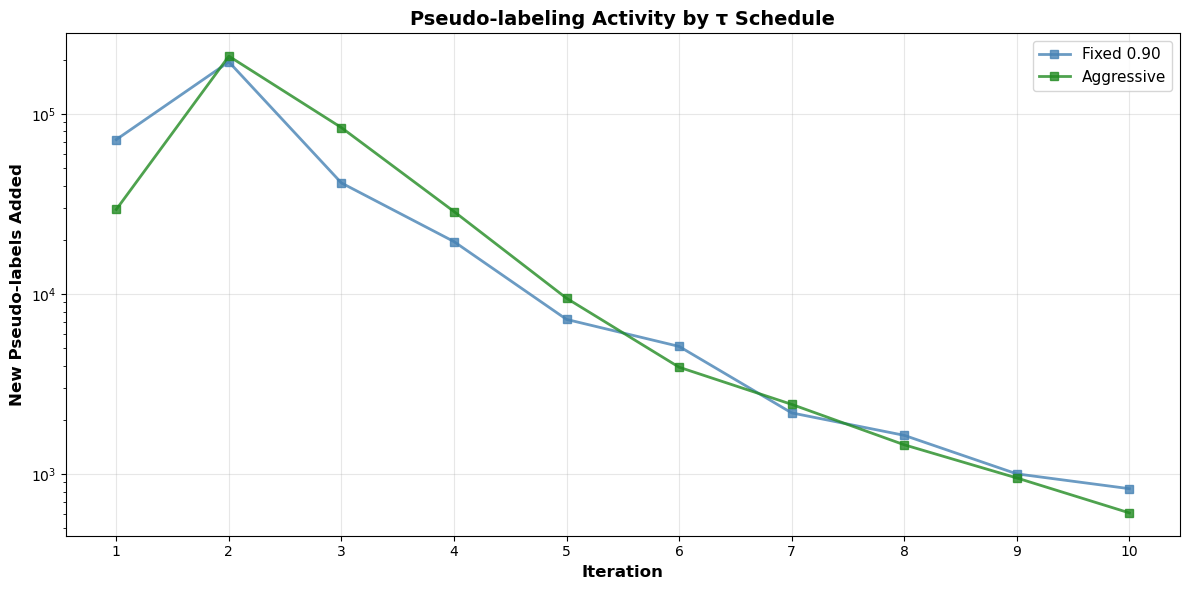

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

for schedule_name, res in results.items():
    history = res["history"]
    iterations = [h["iter"] for h in history]
    new_pseudo = [h["new_pseudo"] for h in history]
    color = schedule_colors[schedule_name]
    
    ax.plot(iterations, new_pseudo, marker='s', linewidth=2,
            label=schedule_name.replace('_', ' '), color=color, alpha=0.8)

ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("New Pseudo-labels Added", fontsize=12, fontweight='bold')
ax.set_title("Pseudo-labeling Activity by τ Schedule", fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 11))
ax.set_yscale('log')

plt.tight_layout()
plot_file = results_dir / "pseudo_labeling_activity.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 4: Total Pseudo-labels Comparison

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\total_pseudo_labels.png


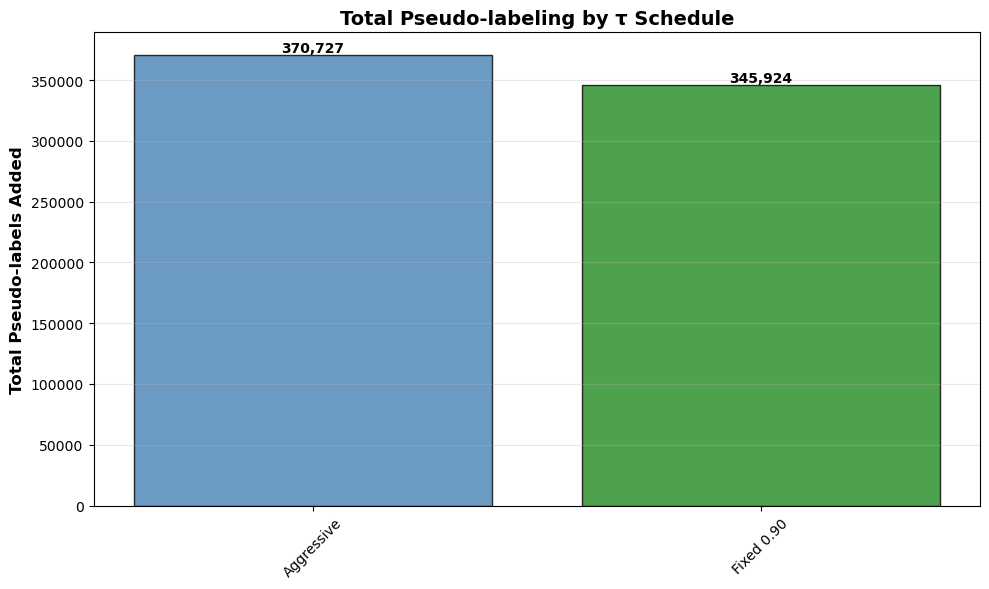

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

schedules_list = summary_df["Schedule"].tolist()
pseudo_totals = summary_df["Pseudo-labels"].tolist()

bars = ax.bar(schedules_list, pseudo_totals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel("Total Pseudo-labels Added", fontsize=12, fontweight='bold')
ax.set_title("Total Pseudo-labeling by τ Schedule", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "total_pseudo_labels.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 5: τ vs Performance Correlation

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\tau_performance_correlation.png


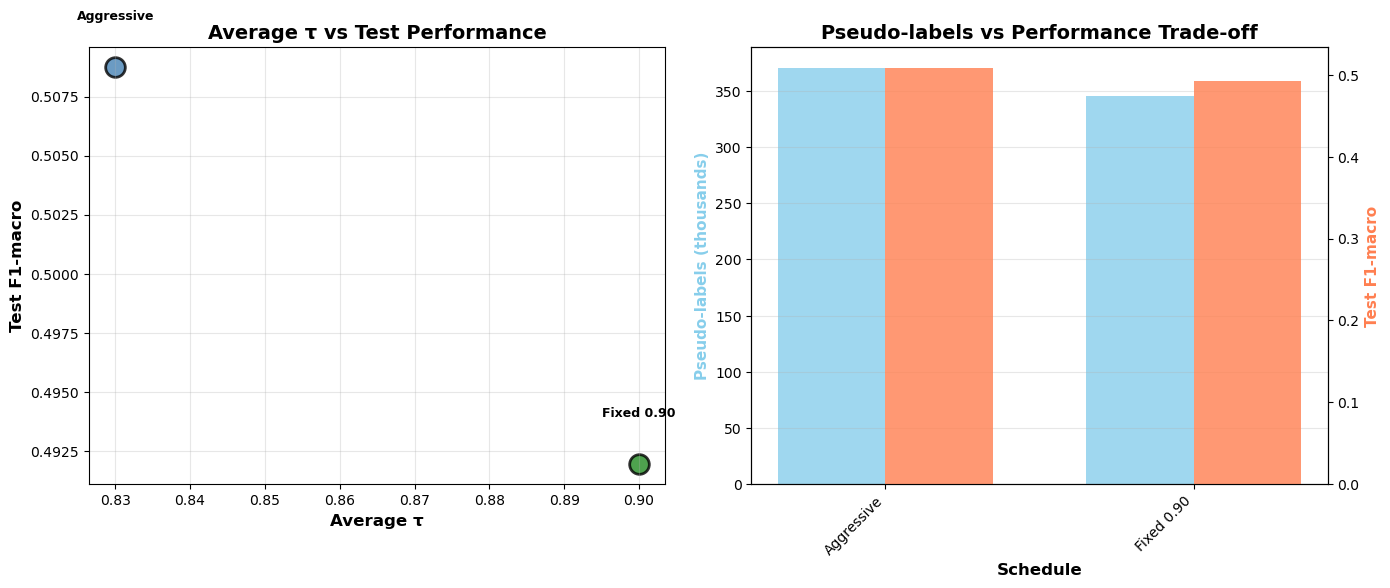

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: Avg τ vs F1
ax1 = axes[0]
avg_taus = summary_df["Avg τ"].tolist()
f1_list = summary_df["Test F1-macro"].tolist()

for i, schedule in enumerate(schedules_list):
    ax1.scatter(avg_taus[i], f1_list[i], s=200, c=colors[i], 
                alpha=0.8, edgecolor='black', linewidth=2)
    ax1.text(avg_taus[i], f1_list[i] + 0.002, schedule,
             ha='center', fontsize=9, fontweight='bold')

ax1.set_xlabel("Average τ", fontsize=12, fontweight='bold')
ax1.set_ylabel("Test F1-macro", fontsize=12, fontweight='bold')
ax1.set_title("Average τ vs Test Performance", fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Bar plot: Pseudo-labels vs F1
ax2 = axes[1]
x = np.arange(len(schedules_list))
width = 0.35

bars1 = ax2.bar(x - width/2, [p/1000 for p in pseudo_totals], width, 
                label='Pseudo-labels (K)', color='skyblue', alpha=0.8)
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, f1_list, width,
                     label='F1-macro', color='coral', alpha=0.8)

ax2.set_xlabel("Schedule", fontsize=12, fontweight='bold')
ax2.set_ylabel("Pseudo-labels (thousands)", fontsize=11, fontweight='bold', color='skyblue')
ax2_twin.set_ylabel("Test F1-macro", fontsize=11, fontweight='bold', color='coral')
ax2.set_title("Pseudo-labels vs Performance Trade-off", fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(schedules_list, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_file = results_dir / "tau_performance_correlation.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Analysis & Insights

In [14]:
print("\n" + "="*100)
print("📊 KEY FINDINGS")
print("="*100)

best_idx = summary_df["Test F1-macro"].idxmax()
best_schedule = summary_df.loc[best_idx]

print(f"\n🏆 Best Schedule: {best_schedule['Schedule']}")
print(f"   Test F1-macro: {best_schedule['Test F1-macro']:.4f}")
print(f"   Test Accuracy: {best_schedule['Test Accuracy']:.4f}")
print(f"   Average τ: {best_schedule['Avg τ']:.3f}")
print(f"   Pseudo-labels: {best_schedule['Pseudo-labels']:,}")
print(f"   Val F1 Peak: {best_schedule['Val F1 Peak']:.4f}")

print(f"\n📈 Ranking by F1-macro:")
for i, row in summary_df.iterrows():
    print(f"   {i+1}. {row['Schedule']}: {row['Test F1-macro']:.4f} (avg τ={row['Avg τ']:.3f})")

print(f"\n💡 Schedule Behaviors:")
baseline_f1 = summary_df[summary_df["Schedule"] == "Fixed 0.90"]["Test F1-macro"].values[0]
for i, row in summary_df.iterrows():
    improvement = (row["Test F1-macro"] - baseline_f1) * 100
    print(f"   {row['Schedule']}:")
    print(f"      - F1 improvement vs Fixed: {improvement:+.2f}%")
    print(f"      - Pseudo-labels: {row['Pseudo-labels']:,}")
    print(f"      - Efficiency: {row['Test F1-macro'] / (row['Pseudo-labels']/1000):.5f} F1 per 1K labels")

print(f"\n🎯 Conclusion:")
if best_schedule["Test F1-macro"] > baseline_f1:
    print(f"   ✅ Hybrid τ strategy IMPROVES over fixed τ!")
    print(f"      Best: {best_schedule['Schedule']}")
    print(f"      Improvement: +{(best_schedule['Test F1-macro'] - baseline_f1)*100:.2f}%")
else:
    print(f"   ⚠️ Fixed τ=0.90 remains competitive")
    print(f"      Hybrid strategies not significantly better")

print(f"\n✅ All visualizations saved to: {results_dir}")
print("="*100)


📊 KEY FINDINGS

🏆 Best Schedule: Aggressive
   Test F1-macro: 0.5088
   Test Accuracy: 0.5689
   Average τ: 0.830
   Pseudo-labels: 370,727
   Val F1 Peak: 0.6673

📈 Ranking by F1-macro:
   2. Aggressive: 0.5088 (avg τ=0.830)
   1. Fixed 0.90: 0.4919 (avg τ=0.900)

💡 Schedule Behaviors:
   Aggressive:
      - F1 improvement vs Fixed: +1.68%
      - Pseudo-labels: 370,727
      - Efficiency: 0.00137 F1 per 1K labels
   Fixed 0.90:
      - F1 improvement vs Fixed: +0.00%
      - Pseudo-labels: 345,924
      - Efficiency: 0.00142 F1 per 1K labels

🎯 Conclusion:
   ✅ Hybrid τ strategy IMPROVES over fixed τ!
      Best: Aggressive
      Improvement: +1.68%

✅ All visualizations saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments


## Dashboard Summary

In [15]:
dashboard_data = {
    "experiment_type": "hybrid_tau_schedule",
    "parameters": {
        "max_iter": MAX_ITER,
        "schedules": {k: v for k, v in TAU_SCHEDULES.items()}
    },
    "summary": summary_df.to_dict(orient='records'),
    "best_schedule": {
        "name": best_schedule["Schedule"],
        "f1_macro": float(best_schedule["Test F1-macro"]),
        "accuracy": float(best_schedule["Test Accuracy"]),
        "avg_tau": float(best_schedule["Avg τ"])
    },
    "baseline_comparison": {
        "fixed_tau_f1": float(baseline_f1),
        "best_hybrid_f1": float(best_schedule["Test F1-macro"]),
        "improvement": float((best_schedule["Test F1-macro"] - baseline_f1) / baseline_f1 * 100)
    },
    "visualizations": [
        "tau_schedules.png",
        "test_performance_by_schedule.png",
        "validation_curves_by_schedule.png",
        "pseudo_labeling_activity.png",
        "total_pseudo_labels.png",
        "tau_performance_correlation.png"
    ]
}

dashboard_file = results_dir / "dashboard_summary.json"
with open(dashboard_file, "w") as f:
    json.dump(dashboard_data, f, indent=2)

print(f"✅ Dashboard summary saved to: {dashboard_file}")
display(Markdown(f"## Experiment Complete! ✅\n\nResults: `{results_dir}`"))

✅ Dashboard summary saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments\dashboard_summary.json


## Experiment Complete! ✅

Results: `D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\hybrid_tau_experiments`